<a href="https://colab.research.google.com/github/mralamdari/CV-Object-Detection-Projects/blob/main/Flower_Recognition_Challenges_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
import tensorflow as tf
from sklearn import preprocessing, model_selection, metrics, decomposition

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/'
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip \*.zip && rm *.zip

In [ ]:
path_folder = '/content/flowers'

size = 224
x_train, x_test = [], []
y_train, y_test = [], []
id = 0
for folder in tqdm.tqdm(os.listdir(path_folder)):
  for files in tqdm.tqdm(os.listdir(os.path.join(path_folder, folder))):
    if files.endswith('jpg'):
      img_path = os.path.join(path_folder, folder, files)
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      im = cv2.resize(img, (size, size))
      im = np.array(im) / 255
      if np.random.rand() < 0.25:
        x_test.append(im)
        y_test.append(folder)
      else:
        x_train.append(im)
        y_train.append(folder)

      id += 1
    else:
      continue

In [3]:
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, 5)
y_test = tf.keras.utils.to_categorical(y_test, 5)

In [4]:
c = list(zip(x_train, y_train))
np.random.shuffle(c)
x_train, y_train = zip(*c)

In [5]:
d = list(zip(x_test, y_test))
np.random.shuffle(d)
x_test, y_test = zip(*d)

In [6]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [7]:
x_train.shape, x_test.shape

((3273, 224, 224, 3), (1044, 224, 224, 3))

In [8]:
len(y_train), len(y_test) 

(3273, 1044)

In [9]:
y_test[:10]

(array([1., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., 1., 0.], dtype=float32),
 array([0., 1., 0., 0., 0.], dtype=float32),
 array([0., 0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 1.], dtype=float32),
 array([0., 0., 1., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0.], dtype=float32))

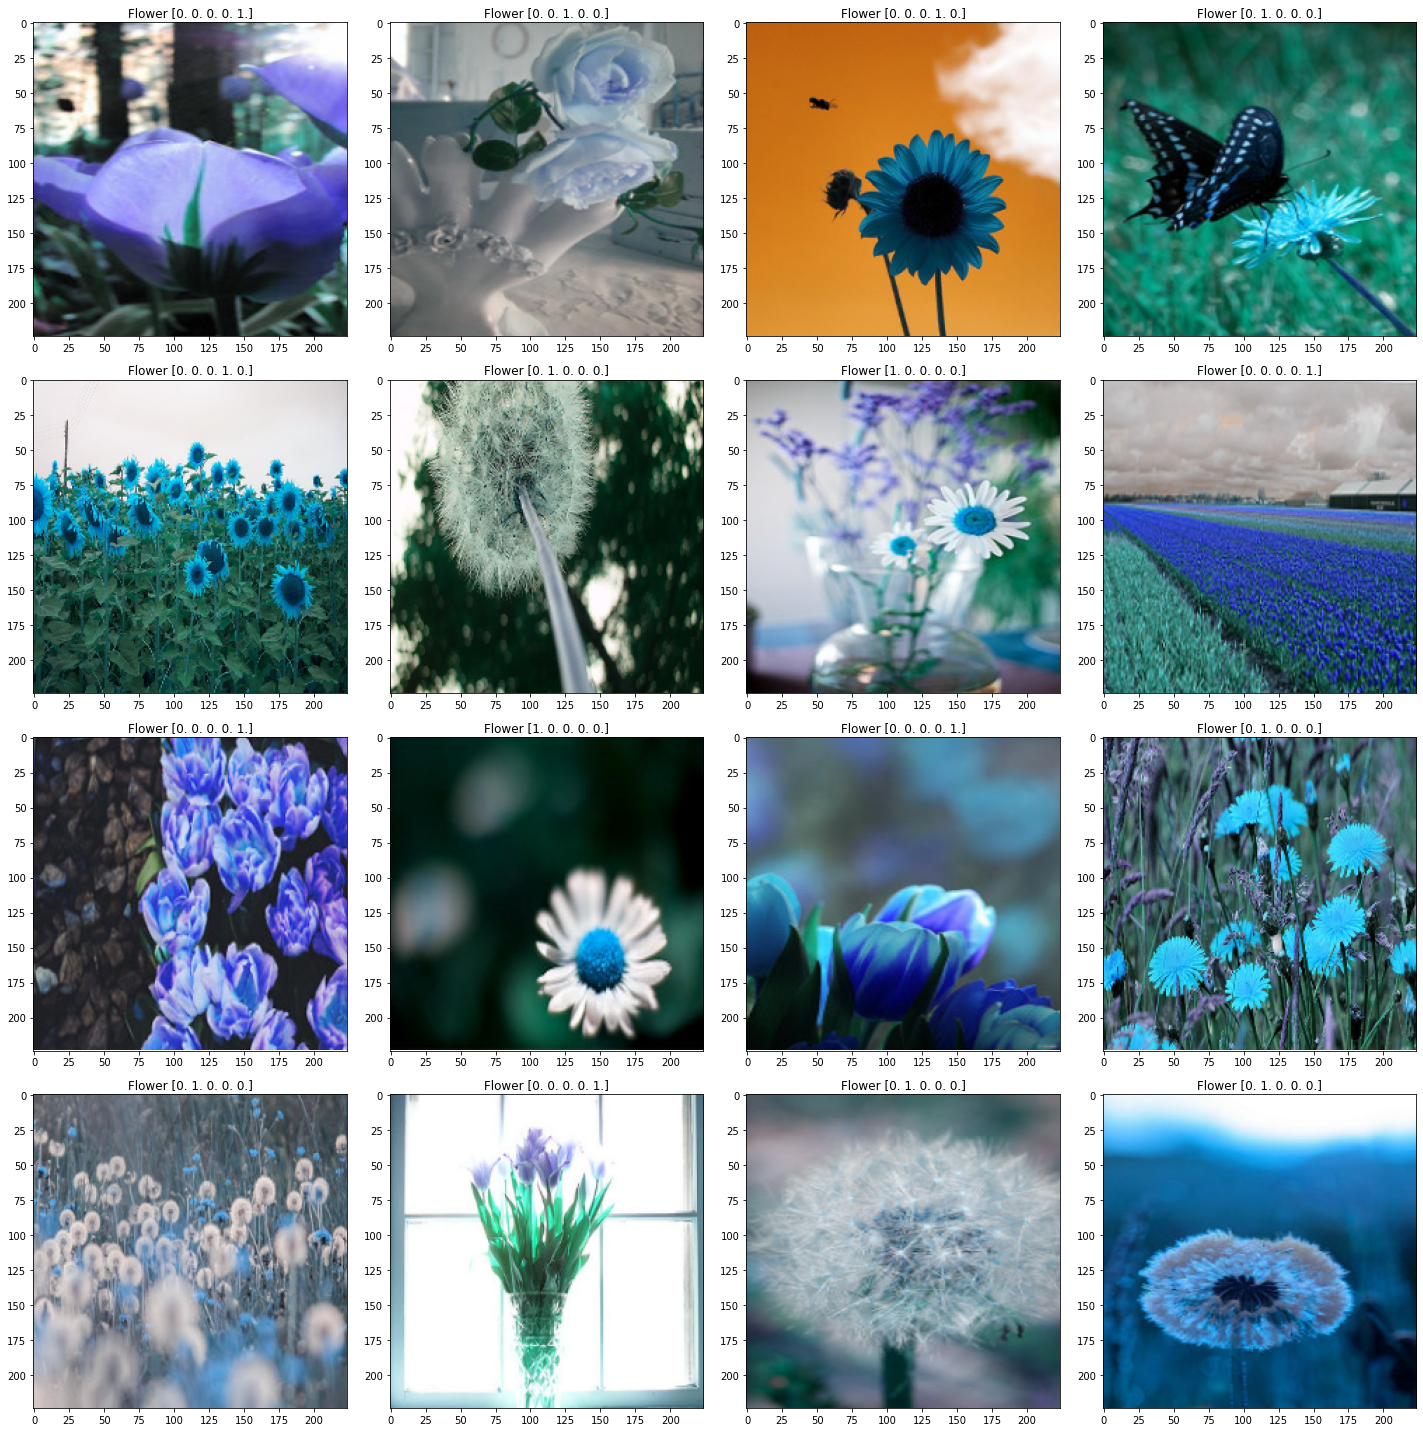

In [8]:
fig, ax = plt.subplots(4, 4)
fig.set_size_inches(20, 20)
for i in range(4):
  for j in range(4):
    rnd = np.random.randint(0, len(x_train), 1)[0]
    ax[i, j].imshow(x_train[rnd])
    ax[i, j].set_title(f'Flower {y_train[rnd]}')
plt.tight_layout()

#Flower Recognition CNN Keras
[Note Book](https://www.kaggle.com/code/rajmehra03/flower-recognition-cnn-keras)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same',activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [ ]:
lr_callback =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', pationce=3, verbose=1, factor=0.1)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
batch_size = 32
history =model.fit(datagen.flow(np.asarray(x_train), y_train, batch_size=batch_size),
                   epochs=1, validation_data=(np.asarray(x_test), y_test), verbose=1)

In [ ]:
def plot_history(hist, loss='True'):
  title = 'loss' if loss else 'accuracy'
  plt.plot(hist.history[f'{title}'])
  plt.plot(hist.history[f'val_{title}'])
  plt.title(f'Model {title}')
  plt.ylabel(f'{title}')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

In [ ]:
plot_history(history)

In [ ]:
plot_history(history, False)

In [ ]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(encoder.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(encoder.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(encoder.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(encoder.inverse_transform(np.argmax([y_test[mis_class[count]]]))))
        plt.tight_layout()
        count+=1

In [ ]:
! wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [14]:
base_model=tf.keras.applications.vgg16.VGG16(include_top=False, weights=None,input_shape=(224,224,3), pooling='avg')

base_model.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [15]:
model=tf.keras.models.Sequential()
model.add(base_model)

model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dense(5,activation='softmax'))

In [16]:
base_model.trainable=False

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [1]:
history = model.fit(datagen.flow(x_train, y_train, batch_Size=32),
                    epochs=1,
                    validation_data=(x_test, y_test),
                    verbose=1, steps_per_epoch=x_train.shape[0]//32)

In [ ]:
for i in range (len(base_model.layers)):
    print (i,base_model.layers[i])
  
for layer in base_model.layers[11:]:
    layer.trainable=True
for layer in base_model.layers[0:11]:
    layer.trainable=False

In [ ]:
model=tf.keras.models.Sequential()
model.add(base_model)

model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dense(5,activation='softmax'))